# Protected Areas

Visualizing % of Exclusive Economic Zones (EEZs) protected over time 

*Author: Rachel Thoms
<br>Created: 08 24 2021
<br>Environment: jupyterlab*

## Style

- Vega chart
- Chart type
- Value 

## Data

- Data: [ow_widget_territory](https://resourcewatch.carto.com/u/wri-rw/dataset/ow_widget_territory) (full dataset - [ocn_023_rw0_marine_protection](https://resourcewatch.carto.com/u/wri-rw/dataset/ocn_023_rw0_marine_protection_edit))
- Resource Watch: [explore page](https://resourcewatch.org/data/explore/)
- Source: [OECD](https://data.oecd.org/biodiver/protected-areas.htm)

## Preparation

### Aliasing and Inserting Data

#### Queries

not inserted into master table

### Vega

In [1]:
import json
from vega import Vega
from IPython.display import display

In [2]:
def Vega(spec):
    bundle = {}
    bundle['application/vnd.vega.v5+json'] = spec
    display(bundle, raw=True)

In [3]:
widget_width = 500
widget_height = 200

## Visualization

### Queries

#### Testing version

```sql
SELECT gadm.gid_0, gadm.name_0, year AS date, value FROM (SELECT iso, country, year, value FROM ocn_023_rw0_marine_protection_edit 
UNION SELECT 'GLB' AS iso, 'Global' as country, year, value FROM ocn_023_rw0_marine_protection_edit WHERE iso='WLD' 
UNION SELECT 'GLB' AS iso, country, year, value FROM ocn_023_rw0_marine_protection_edit WHERE iso='ABNJ') AS data
LEFT OUTER JOIN gadm36_0 gadm ON data.iso = gadm.gid_0  
WHERE gadm.geostore_prod = 'f4599aaeedacb9e6ddca177a93795e4c' ORDER BY date ASC, name_0 ASC
```

#### Parameterized version

```sql
SELECT gadm.gid_0, gadm.name_0, year AS date, value FROM 
(SELECT iso, country, year, value FROM ocn_023_rw0_marine_protection_edit UNION SELECT 'GLB' AS iso, 'Global' as country, year, value FROM ocn_023_rw0_marine_protection_edit 
WHERE iso='WLD' 
UNION SELECT 'GLB' AS iso, country, year, value FROM ocn_023_rw0_marine_protection_edit WHERE iso='ABNJ') AS data 
LEFT OUTER JOIN gadm36_0 gadm ON data.iso = gadm.gid_0 WHERE gadm.{{geostore_env}} = '{{geostore_id}}' 
ORDER BY date ASC, name_0 ASC
```

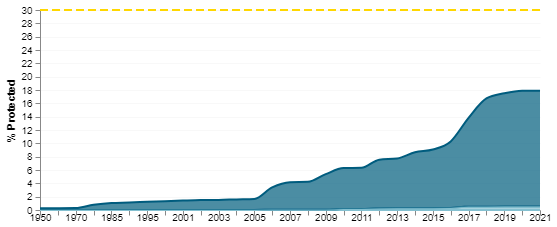

In [4]:
spec=json.loads("""{
  "$schema": "https://vega.github.io/schema/vega/v5.json",
  "description": "A basic line chart example.",
  "width": 500,
  "height": 200,
  "padding": 5,
  "data": [
    {
      "name": "table",
      "url": "https://wri-rw.carto.com/api/v2/sql?q= SELECT * from (SELECT alias.iso AS gid_0, alias.name_0 AS name_0, year as date, value FROM ocn_023_rw0_marine_protection_edit AS data INNER JOIN ow_aliasing_countries AS alias ON alias.iso = data.iso UNION SELECT 'X01' AS gid_0, 'World EEZs' as name_0, year as date, value FROM ocn_023_rw0_marine_protection_edit WHERE iso='WLD' UNION SELECT 'X01' AS gid_0, country as name_0, year as date, value FROM ocn_023_rw0_marine_protection_edit WHERE iso='ABNJ') query WHERE gid_0 = 'X01' ORDER BY date ASC, name_0 ASC",
      "format": {"type": "json", "property": "rows"}},
      {"name": "maximum",
    "source": "table",
    "transform": [{"type": "collect", "sort": {"field": "value","order": "descending"}}
  ]},
      {"name": "mpa",
      "source": "table",
      "transform": [
        {
          "type": "stack",
          "groupby": ["date"],
          "sort": {"field": "name_0"},
          "field": "value"
        },
        {"type": "formula",
        "expr": "datum.y0 + datum.y1",
        "as": "total"},
        {"type": "collect", "sort": {"field": ["date","name_0"],"order": ["ascending", "ascending"]}}
      ]
    },
    {
      "name": "highlightedPoint",
      "source": "mpa",
      "transform": [
        {
          "type": "filter",
          "expr": "(point_hover && point_hover.datum.date === datum.date) "
        }
      ]
    }],
  "signals": [
    {
      "name": "point_hover",
      "value": null,
      "on": [
        {"events": "@points_voronoi:mouseover", "update": "datum"},
        {"events": "@points_voronoi:mouseout", "update": "null"}
      ]
    },
    {"name": "gid", "update": "data('mpa')[0]['gid_0']"},
    {"name": "max", "update": "data('maximum')[0]['value']"}
  ],
  "scales": [
    {
      "name": "x",
      "type": "point",
      "range": "width",
      "domain": {"data": "mpa", "field": "date"}
    },
    {
      "name": "y",
      "type": "linear",
      "range": "height",
      "nice": true,
      "zero": true,
      "domain": {"data": "mpa", "field": "value"},
      "domainMax": {"signal": "gid === 'X01' ? 30 : max <80 ? max + 20 : 100"}
    },
    {
      "name": "colors",
      "type": "ordinal",
      "range": ["#84c0d0", "#005c7e"],
      "domain": {"data": "mpa", "field": "name_0"}
    
    },
    {
      "name": "color",
      "type": "ordinal",
      "range": ["#005c7e"],
      "domain": {"data": "mpa", "field": "name_0"}
    }
  ],
  "axes": [
    {
      "orient": "bottom",
      "scale": "x",
      "labelBaseline": "middle",
      "labelOverlap": true,
      "labelFontSize": 10,
      "labelFont": "Arial"
    },
    {
      "orient": "left",
      "scale": "y",
      "title": "% Protected",
      "labelBaseline": "middle",
      "labelAlign": "right",
      "labelPadding": 3,
      "grid": true,
      "gridOpacity": 0.2,
      "labelFontSize": 10,
      "labelFont": "Arial"
    }
  ],
  "marks": [
    {
      "type": "group",
      "from": {"facet": {"name": "series", "data": "mpa", "groupby": "name_0"}},
      "marks": [
        {
          "type": "line",
          "from": {"data": "series"},
          "encode": {
            "enter": {
              "x": {"scale": "x", "field": "date"},
              "y": {"scale": "y", "field": "y0"},
              "stroke": {"value": "#84c0d0"},
              "strokeWidth": {"value": 2}
            },
            "update": {
              "interpolate": {"value": "monotone"},
              "strokeOpacity": {"value": 1}
            },
            "hover": {"strokeOpacity": {"value": 0.5}}
          }
        },
        {
          "type": "line",
          "from": {"data": "series"},
          "encode": {
            "enter": {
              "x": {"scale": "x", "field": "date"},
              "y": {"scale": "y", "field": "y1"},
              "stroke": {"value": "#005c7e"},
              "strokeWidth": {"value": 2}
            },
            "update": {
              "interpolate": {"value": "monotone"},
              "strokeOpacity": {"value": 1}
            },
            "hover": {"strokeOpacity": {"value": 0.5}}
          }
        },
        {
          "type": "area",
          "from": {"data": "series"},
          "encode": {
            "enter": {
              "x": {"scale": "x", "field": "date"},
              "y": {"scale": "y", "field": "y0"},
              "y2": {"scale": "y","field": "y1"},
              "fill": {"scale": {"signal": "(datum.gid_0=== 'X01' ? 'colors' : 'color')"}, "field": "name_0"}
            },
            "update": {
              "interpolate": {"value": "monotone"},
              "fillOpacity": {"value": 0.7}
            },
            "hover": {"fillOpacity": {"value": 0.5}}
          }
        },
        {
          "name": "points",
          "type": "symbol",
          "from": {"data": "mpa"},
          "encode": {
            "update": {
              "x": {"scale": "x", "field": "date"},
              "y": {"scale": "y", "field": "y1"},
              "size": {"value": 6},
              "shape": {"value": "circle"},
              "strokeWidth": {"value": 2},
              "opacity": {"value": 1},
              "stroke": {"value": "transparent"},
              "fill": {"value": "transparent"}
            }
          }
        },
        {
          "name": "points_voronoi",
          "type": "path",
          "from": {"data": "points"},
          "encode": {
            "update": {
              "fill": {"value": "transparent"},
              "strokeWidth": {"value": 0.35},
              "stroke": {"value": "transparent"},
              "strokeOpacity": {"value": 0.2},
              "isVoronoi": {"value": true},
              "tooltip": {
                "signal": "{'Area':datum.datum.name_0, 'Year':datum.datum.date,'% protected':format(datum.datum.value,'.1f') + '%'}"
              }
            }
          },
          "transform": [
            {
              "type": "voronoi",
              "x": "datum.x",
              "y": "datum.y",
              "extent": {"signal": "[[0, 0],[width, height]]"}
            }
          ]
        },
        {
          "from": {"data": "highlightedPoint"},
          "type": "symbol",
          "interactive": false,
          "encode": {
            "update": {
              "x": {"scale": "x", "field": "date"},
              "y": {"scale": "y", "field": "y1"},
              "stroke": {"scale": {"signal": "(datum.gid_0=== 'X01' ? 'colors' : 'color')"}, "field": "name_0"},
              "strokeWidth": {"value": 4},
              "fill": {"value": "white"},
              "size": {"value": 150},
              "strokeOpacity": {"value": 0.8}
            }
          }
        },
        {
          "name": "line",
          "from": {"data": "mpa"},
          "type": "line",
          "encode": {
            "enter": {
              "x": {"scale": "x", "field": "date"},
              "y": {"scale": "y", "value": "max"},
              "strokeOpacity": {"signal": "gid === 'X01' ? 1 : 0"},
              "stroke": {"value": "gold"},
              "strokeDash": {"value": [8, 4]},
              "tooltip": {
                "signal": "{'Post-2020 global biodiversity framework target' : '30%'}"
              }
            }
          }
        }
      ]
    }
  ]
}""")
vegaview=dict(spec)
Vega(vegaview)

## RW Backoffice

- [back office](https://resourcewatch.org/admin/data/widgets/92e5286e-b40a-4a6f-a3e5-84ac9b49d459/edit?dataset=40c8d7b8-36b6-4f07-8941-cc61dc62fc12)
- parent dataset [ocn.023](https://resourcewatch.org/data/explore/40c8d7b8-36b6-4f07-8941-cc61dc62fc12) (unpublished)
- dataset id ```40c8d7b8-36b6-4f07-8941-cc61dc62fc12```
- widget id: ```92e5286e-b40a-4a6f-a3e5-84ac9b49d459```